Step 1: Set Up the Environment and Load Data

In [1]:
spark

In [2]:
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col






In [3]:
# Import some modules we will need later on
from pyspark.sql.functions import col, isnan, when, count, udf, to_date, year, month, date_format, size, split, unix_timestamp
from pyspark.ml.stat import Correlation
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [4]:
# Set up the path to an Amazon reviews data stored on GCS
bucket = 'my-bigdata-project-md/'
filename = 'cleaned/yellow_tripdata_2023-12.parquet'
file_path = 'gs://' + bucket + filename

sdf=spark.read.parquet(file_path)

In [5]:
sdf.printSchema()

root
 |-- Pick_up_time: timestamp_ntz (nullable = true)
 |-- Drop_off_time: timestamp_ntz (nullable = true)
 |-- Passenger_count: double (nullable = true)
 |-- Trip_distance: double (nullable = true)
 |-- Pick_up_location: long (nullable = true)
 |-- Drop_off_location: long (nullable = true)
 |-- Fare_amount: double (nullable = true)
 |-- Extra_charge: double (nullable = true)
 |-- Mta_tax: double (nullable = true)
 |-- Tip_amount: double (nullable = true)
 |-- Tolls_amount: double (nullable = true)
 |-- Improvement_surcharge: double (nullable = true)
 |-- Total_amount: double (nullable = true)
 |-- __index_level_0__: long (nullable = true)



In [6]:
# Convert the date column to an actual date data type
sdf = sdf.withColumn('Pick_up_time', to_date(sdf.Pick_up_time, 'yyyy-MM-dd'))
sdf = sdf.withColumn('Drop_off_time', to_date(sdf.Drop_off_time, 'yyyy-MM-dd'))

'''# Engineer additional date feature columns based on the order_date
sdf = sdf.withColumn("order_year", year(col("order_date")))
sdf = sdf.withColumn("order_month", month(col("order_date")))
sdf = sdf.withColumn("order_yearmonth", date_format(col("order_date"), "yyyy-MM"))   # Like 2023-01   2023-02 etc.
sdf = sdf.withColumn("order_dayofweek", date_format(col("order_date"), "E"))         # 'Monday' 'Tuesday' etc.
sdf = sdf.withColumn("order_weekend", when(sdf.order_dayofweek == 'Saturday',1.0).when(sdf.order_dayofweek == 'Sunday', 1.0).otherwise(0))
'''

'# Engineer additional date feature columns based on the order_date\nsdf = sdf.withColumn("order_year", year(col("order_date")))\nsdf = sdf.withColumn("order_month", month(col("order_date")))\nsdf = sdf.withColumn("order_yearmonth", date_format(col("order_date"), "yyyy-MM"))   # Like 2023-01   2023-02 etc.\nsdf = sdf.withColumn("order_dayofweek", date_format(col("order_date"), "E"))         # \'Monday\' \'Tuesday\' etc.\nsdf = sdf.withColumn("order_weekend", when(sdf.order_dayofweek == \'Saturday\',1.0).when(sdf.order_dayofweek == \'Sunday\', 1.0).otherwise(0))\n'

In [7]:
spark.conf.set("spark.sql.debug.maxToStringFields", 1000)


In [8]:

# Get the number of records
sdf.count()
# Look at statistics for some specific columns
sdf.select("Tip_amount", "Passenger_count", "Trip_distance", 'Fare_amount','Extra_charge', 'Mta_tax' ).summary("count", "min", "max", "mean").show()


+-------+------------------+------------------+-----------------+------------------+------------------+-------------------+
|summary|        Tip_amount|   Passenger_count|    Trip_distance|       Fare_amount|      Extra_charge|            Mta_tax|
+-------+------------------+------------------+-----------------+------------------+------------------+-------------------+
|  count|           3196564|           3196564|          3196564|           3196564|           3196564|            3196564|
|    min|             -80.0|               0.0|              0.0|           -1087.3|              -7.5|               -0.5|
|    max|            4174.0|               9.0|         161726.1|           2320.11|             51.68|                4.0|
|   mean|3.6171194257332635|1.4081617011265846|3.385364966883123|19.507900261031146|1.5540335560307876|0.48218587520850514|
+-------+------------------+------------------+-----------------+------------------+------------------+-------------------+



In [9]:
# Get the number of records
sdf.count()
# Look at statistics for some specific columns
sdf.select('Tolls_amount', 'Improvement_surcharge', 'Total_amount' ).summary("count", "min", "max", "mean").show()


+-------+------------------+---------------------+------------------+
|summary|      Tolls_amount|Improvement_surcharge|      Total_amount|
+-------+------------------+---------------------+------------------+
|  count|           3196564|              3196564|           3196564|
|    min|             -70.0|                 -1.0|          -1094.05|
|    max|            161.38|                  1.0|           4269.16|
|   mean|0.5822262623237506|   0.9747744453106537|28.541455472218313|
+-------+------------------+---------------------+------------------+



REMOVING THE OUTLIER 

In [10]:
# Filter out tips greater than $25 and trips longer than 50 miles
filtered_data = sdf.filter((col("Tip_amount") <= 25) & (col("Trip_distance") <= 50))

# Display the count of records after filtering
print("Filtered records:", filtered_data.count())


Filtered records: 3189966


FEATURE ENGINEERING : ASSEMBLING INTO A FEATUTE VECTOR, NORMALIZING FEATURE, PREPARING THE DATA FOR MODELING 

In [11]:
# Feature Engineering: Create trip duration in minutes
filtered_data = filtered_data.withColumn("Trip_duration", 
                (unix_timestamp("Drop_off_time") - unix_timestamp("Pick_up_time")) / 60)

# Assemble features into a feature vector
feature_columns = ["Trip_distance", "Fare_amount", "Extra_charge", "Mta_tax", 
                   "Tolls_amount", "Improvement_surcharge", "Trip_duration"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Normalize features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Prepare the data for modeling
assembled_data = assembler.transform(filtered_data)
prepared_data = scaler.fit(assembled_data).transform(assembled_data)

# Show sample of the prepared data
prepared_data.select("features", "scaled_features").show(5, truncate=False)


+------------------------------+-------------------------------------------------------------------------------------------------------+
|features                      |scaled_features                                                                                        |
+------------------------------+-------------------------------------------------------------------------------------------------------+
|[1.1,10.0,3.5,0.5,0.0,1.0,0.0]|[0.2548144796772753,0.5455992807418245,1.9164800799998853,4.162734764037241,0.0,4.493457611038088,0.0] |
|[1.5,9.3,3.5,0.5,0.0,1.0,0.0] |[0.3474742904690117,0.5074073310898969,1.9164800799998853,4.162734764037241,0.0,4.493457611038088,0.0] |
|[2.2,13.5,3.5,0.5,0.0,1.0,0.0]|[0.5096289593545505,0.7365590290014631,1.9164800799998853,4.162734764037241,0.0,4.493457611038088,0.0] |
|[0.66,7.2,1.0,0.5,0.0,1.0,0.0]|[0.15288868780636516,0.3928314821341137,0.5475657371428244,4.162734764037241,0.0,4.493457611038088,0.0]|
|[2.2,11.4,1.0,0.5,0.0,1.0,0.0]|[0.509628

TRAIN/TEST SPLIT 

In [12]:
train_data, test_data = prepared_data.randomSplit([0.8, 0.2], seed=42)

MODEL TRAINING AND EVALUATION 

In [13]:
# Linear Regression Model
lr = LinearRegression(featuresCol="scaled_features", labelCol="Tip_amount", predictionCol="prediction")

# Train the model
lr_model = lr.fit(train_data)

# Make predictions
predictions = lr_model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="Tip_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")


24/05/18 05:57:52 WARN Instrumentation: [77ba9ca7] regParam is zero, which might cause numerical instability and overfitting.


Root Mean Squared Error (RMSE): 3.000726294819503


SAVING PROCESSED DATA AND MODEL INTO TRUSTED AND MODEL FILES 

In [14]:
#Save the processed data to the /trusted folder
prepared_data.write.mode("overwrite").parquet("gs://my-bigdata-project-md/trusted/")

#Save the model to the /models folder
lr_model.save("gs://my-bigdata-project-md/models/lr_model")


DATA VISUALIZATION 

In [17]:


# Convert the Spark DataFrame to Pandas DataFrame
sdf_pd = sdf.toPandas()
filtered_data_pd = filtered_data.toPandas()
predictions_pd = predictions.select('Tip_amount', 'prediction').toPandas()  # Ensure you have a DataFrame with predictions


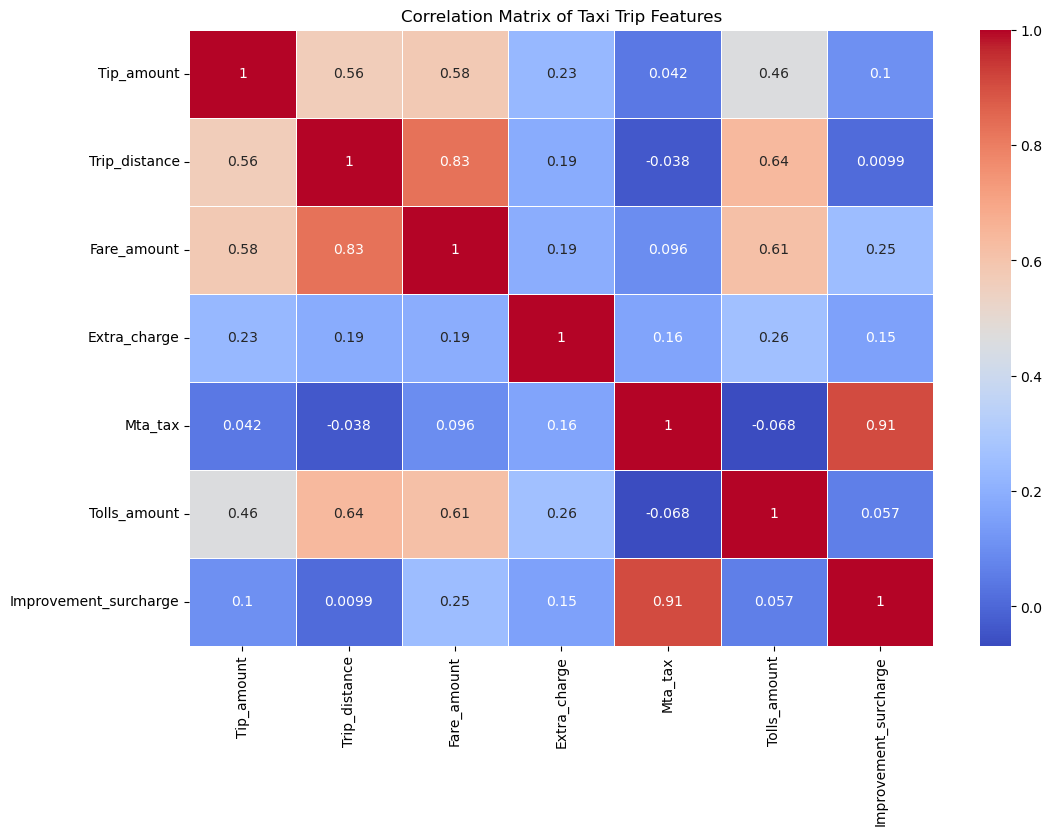

In [19]:

plt.figure(figsize=(12, 8))
corr_matrix = filtered_data_pd[['Tip_amount', 'Trip_distance', 'Fare_amount', 'Extra_charge', 'Mta_tax', 'Tolls_amount', 'Improvement_surcharge']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Taxi Trip Features')
plt.savefig('visualization_correlation_matrix.png')
plt.show()


Summary of the Correlation Matrix
​
Strong Correlation:
​
Fare Amount & Trip Distance: Longer trips have higher fares (0.83).
Tolls Amount & Trip Distance: Longer trips incur higher tolls (0.64).
Fare Amount & Tolls Amount: Higher fares often include higher tolls (0.61).
    
Moderate Correlation:
​
    Tip Amount & Fare Amount: Higher fares generally lead to higher tips (0.58).
Tip Amount & Trip Distance: Longer trips typically get higher tips (0.56).
    
    
Weak Correlation:
​
Extra Charge & MTA Tax: Minimal impact on tips, fares, or distances.
    
Conclusion:
Fare amount and trip distance are key factors affecting tip amounts, while extra charges and MTA tax have minimal impact.


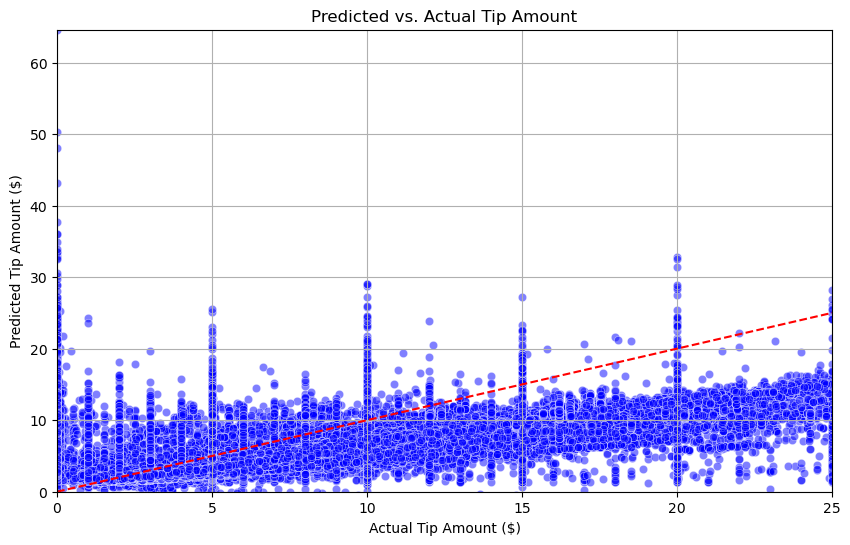

In [20]:

import matplotlib.pyplot as plt
import seaborn as sns

# Improved Visualization: Scatter Plot of Predicted vs. Actual Tip Amount
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Tip_amount', y='prediction', data=predictions_pd, alpha=0.5, color='blue')
plt.plot([0, predictions_pd['Tip_amount'].max()], [0, predictions_pd['Tip_amount'].max()], color='red', linestyle='--')
plt.title('Predicted vs. Actual Tip Amount')
plt.xlabel('Actual Tip Amount ($)')
plt.ylabel('Predicted Tip Amount ($)')
plt.xlim(0, predictions_pd['Tip_amount'].max())
plt.ylim(0, predictions_pd['prediction'].max())
plt.grid(True)
plt.savefig('visualization_predicted_vs_actual_better.png')
plt.show()



Summary of the Predicted vs. Actual Tip Amount Plot :

Underprediction: The model generally underpredicts tips, especially higher amounts.

Accurate for Low Tips: Predictions are accurate for low tips (0-5 dollars).

Decreasing Accuracy: Model accuracy decreases as tip amounts increase.

Outliers: Significant prediction errors indicate areas for improvement.

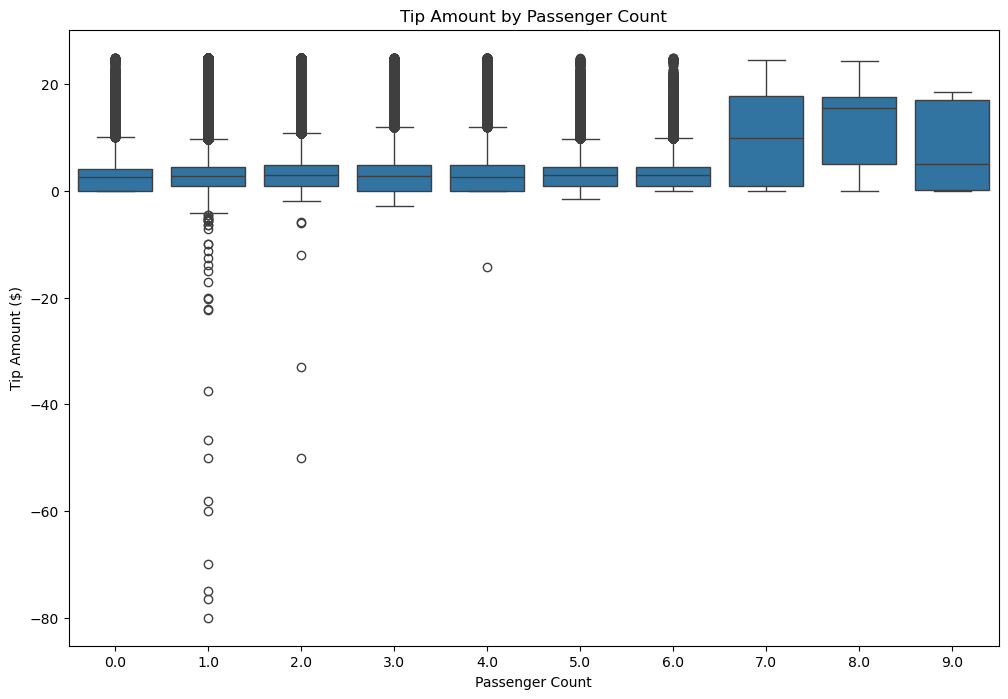

In [22]:
# Visualization 5: Box Plot of Tip Amount by Passenger Count
plt.figure(figsize=(12, 8))
sns.boxplot(x='Passenger_count', y='Tip_amount', data=filtered_data_pd)
plt.title('Tip Amount by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Tip Amount ($)')
plt.savefig('visualization_tip_by_passenger_count.png')
plt.show()

SUMMARY:

Higher Tips for Larger Groups: Groups of 7-9 passengers tend to tip more.

Negative Tips and Outliers: Many outliers, especially for single passengers, suggest data errors or service issues.

Consistent Tips for Smaller Groups: Tips for 1-4 passengers are stable, implying other factors affect tips more.

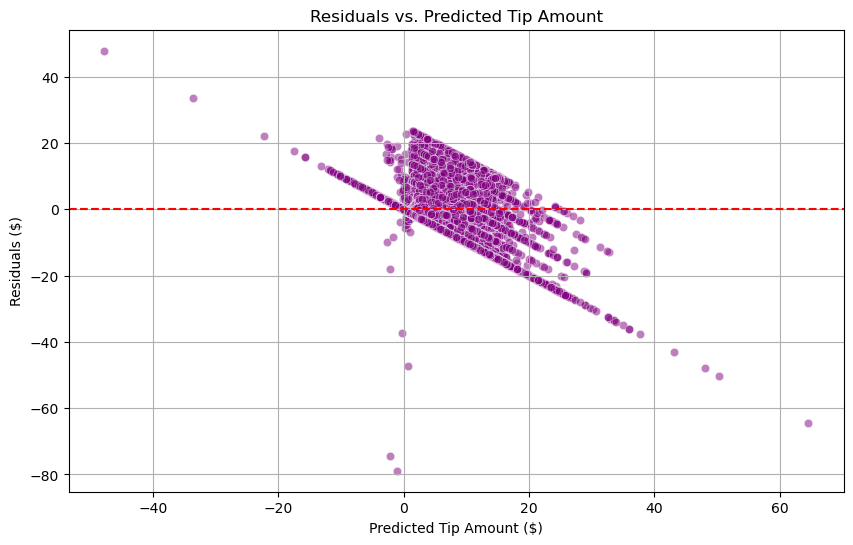

In [23]:
# Visualization 6: Residual Plot
predictions_pd['residuals'] = predictions_pd['Tip_amount'] - predictions_pd['prediction']
plt.figure(figsize=(10, 6))
sns.scatterplot(x='prediction', y='residuals', data=predictions_pd, alpha=0.5, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted Tip Amount')
plt.xlabel('Predicted Tip Amount ($)')
plt.ylabel('Residuals ($)')
plt.grid(True)
plt.savefig('visualization_residuals.png')
plt.show()

The residual plot shows:

Underestimation of Higher Tips: The model often underpredicts higher tips.

Overestimation of Lower Tips: The model tends to overpredict lower tips.

Outliers: Significant outliers indicate the model struggles with certain data points.